# Exercício de Extreme Learning Machines

In [112]:
import numpy as np
import matplotlib.pyplot as plt

### Exercício 1


In [125]:
#Gerando dados sinteticos
np.random.seed(20)
n = 30

x1 = np.random.normal(loc = 1,size=n,scale=0.8)
    
y1 = np.random.normal(loc = 1,size=n,scale=0.8)

x2 = np.random.normal(loc = 3,size=n,scale=0.8)

y2 = np.random.normal(loc = 3, size=n,scale=0.8)

x = np.vstack([
    np.column_stack([x1,y1]),
    np.column_stack([x2,y2])
    ])

x = np.column_stack([np.ones(len(x)),x])
y = np.hstack([
    -1*np.ones(len(x1),dtype=np.int8),
    np.ones(len(x1),dtype=np.int8),
    
    ])

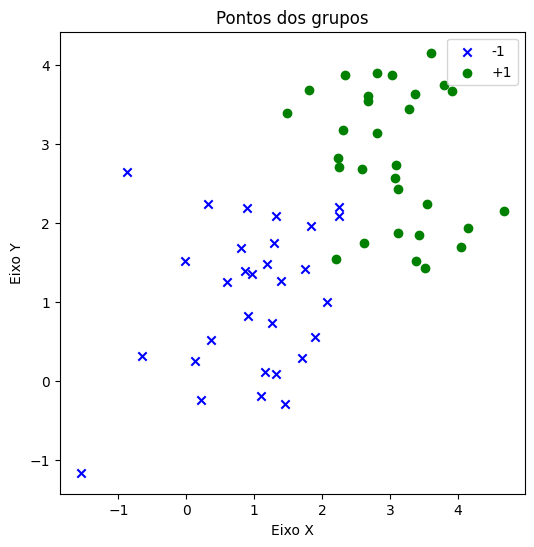

In [126]:
#Plotando dados
plt.figure(figsize=(6,6))

plt.scatter(x=x1,y=y1,color = 'blue',label = '-1',marker= 'x')
plt.scatter(x=x2,y=y2,color = 'green',label = '+1', marker='o')

plt.title("Pontos dos grupos")
plt.xlabel("Eixo X")
plt.ylabel("Eixo Y")
plt.legend()

plt.show()

In [127]:
def ajuste(x, y, Z, lamb = 0.1 ,not_intercept = False):
    
    
    if(not_intercept == True):
        x = np.column_stack([
            np.ones(len(x)),
            x
        ])
        
    H = np.tanh(x@Z)
    w = np.linalg.inv(np.transpose(H) @ H - lamb * np.identity(H.shape[1])) @ np.transpose(H) @ y
    return w

def predict(x,w,Z):
    H = np.tanh(x@Z)
    y = H@w

    return y


In [128]:

Z = np.random.randn(3,30)
w = ajuste(x,y,Z,lamb=0.01)

y_hat = predict(x,w,Z)

In [129]:
def plot_contorno(x, y, Z, lambs, not_intercept=False):

    if not_intercept:
        x = np.column_stack([np.ones(len(x)), x])

    # Camada oculta
    H = np.tanh(x @ Z)

    # Grid no plano 2D original
    x_min, x_max = x[:,1].min()-0.5, x[:,1].max()+.5
    y_min, y_max = x[:,2].min()-.5, x[:,2].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_aug = np.c_[np.ones(grid_points.shape[0]), grid_points]  # adiciona intercepto
    grid_proj = np.tanh(grid_aug @ Z)

    # Para cada lambda, ajusta o separador e plota
    for lamb in lambs:
        w = ajuste(x, y, Z, lamb)
        scores = np.tanh(grid_proj @ w)
        z = scores.reshape(xx.shape)

        plt.figure(figsize=(6,6))
        plt.contourf(xx, yy, z, levels=[-np.inf,0,np.inf], alpha=0.2, colors=["blue","green"])
        plt.contour(xx, yy, z, levels=[0], colors="k", linewidths=2)

        plt.scatter(x[y==-1,1], x[y==-1,2], color="blue", label="-1", marker= 'x')
        plt.scatter(x[y==+1,1], x[y==+1,2], color="green", label="+1",marker='o')

        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title(r"Separador para $\lambda = {}$".format(lamb))
        plt.legend()
        plt.show()

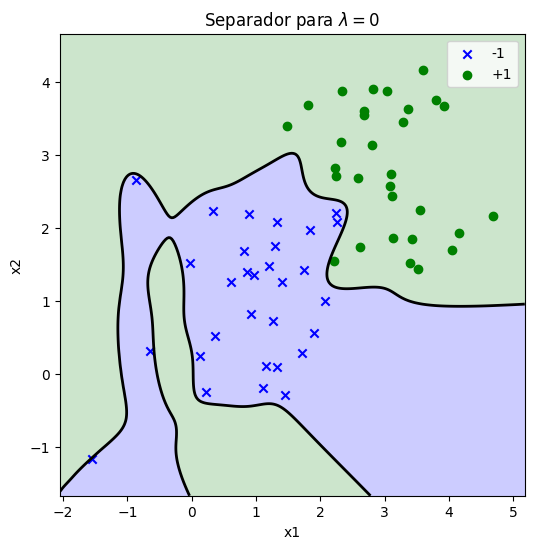

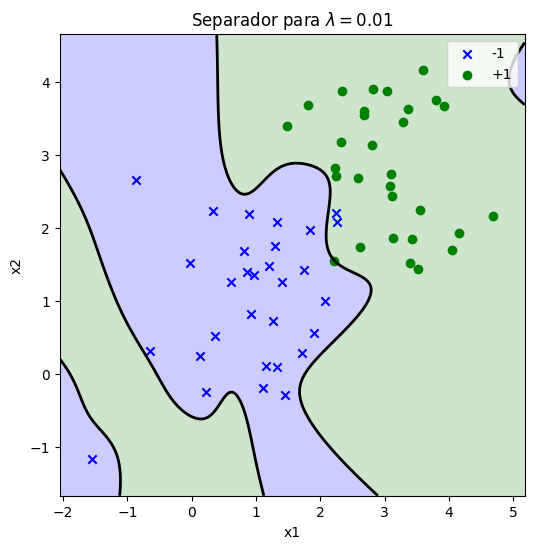

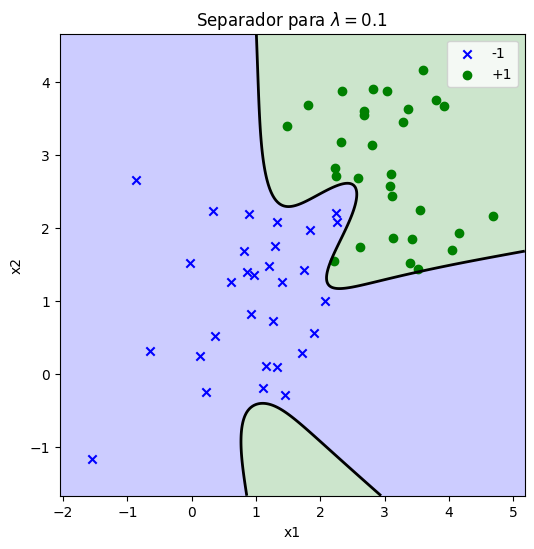

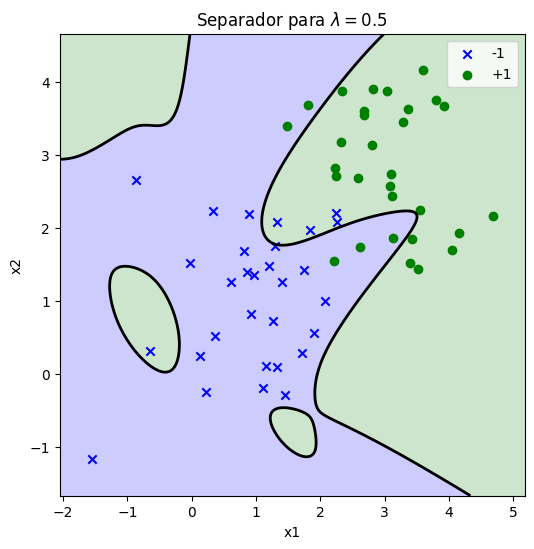

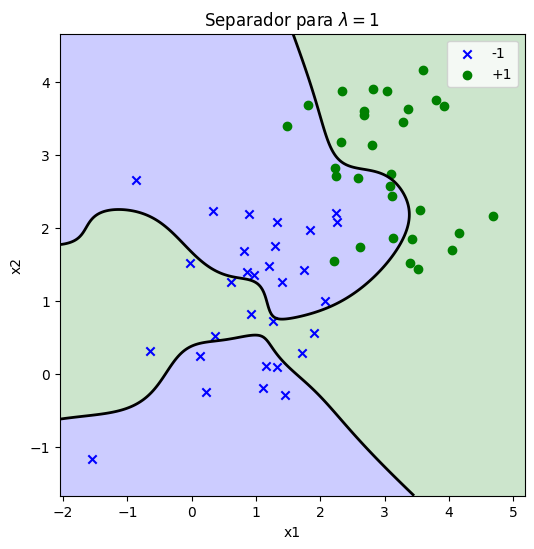

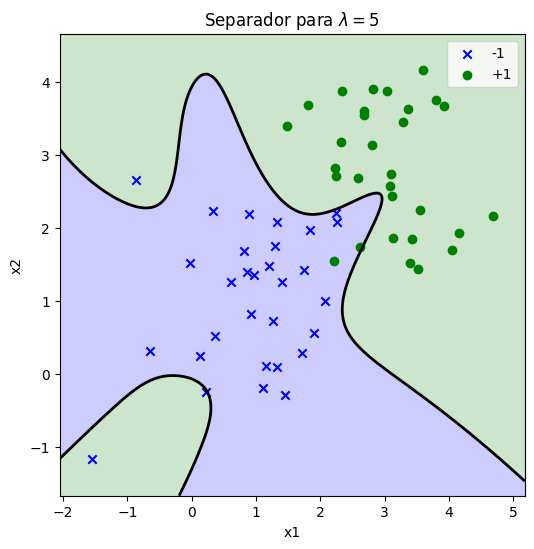

In [131]:
plot_contorno(x,y,Z,lambs= [0,0.01,0.1,0.5,1,5])

## Discussão

Foi adotada a seguinte sequencia para ajuste: 

$$ X \to XZ \to H = tanh(XZ) \to w = (H'H - \lambda I)^{-1}H'y $$


A função tanh permite projetar X em um espaço de dimensão maior de forma não-linear, o que é essencial para tornar as observações linearmente separáveis. 

Optou-se por uma projeção de dimensão elevada justamente para forçar o overfitting. Observa-se que, para $\lambda = 0$, diversos pontos do conjunto de dados residem exatamente na fronteira de separação, refletindo o ajuste excessivo do modelo aos dados de treino. À medida que $\lambda$ aumenta, as curvas de separação tornam-se progressivamente mais suaves, reduzindo o overfit até que, para valores muito grandes de $\lambda$, ocorre underfitting.

### Exercício 2


In [96]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

data = load_breast_cancer()
X = data.data
y = data.target  # 0 = malignant, 1 = benign

# Split estratificado (mesmo que você usou)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=40
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train = np.column_stack([np.ones(len(X_train)), X_train])
X_test  = np.column_stack([np.ones(len(X_test)),  X_test])




In [102]:
import numpy as np
from sklearn.metrics import accuracy_score

class ELM:
    def __init__(self, n_hidden, random_state=0):
        """
        n_hidden: int (número de neurônios na camada oculta)
        """
        self.n_hidden = n_hidden
        self.random_state = random_state
        
        self.weights_input = None   # W (n_features, n_hidden)
        self.bias_hidden = None     # b (n_hidden,) -> Viés aleatório é crucial para ELM
        self.weights_output = None  # Beta (n_hidden + 1, 1)

    def _sigmoid(self, x):
        # Clip para evitar overflow numérico na exponencial
        x = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x))

    def fit(self, X, y, lamb=0.01):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)

        # 1. Inicialização Aleatória (Input Weights + Hidden Bias)
        self.weights_input = rng.uniform(-1.5, 1.5, (n_features, self.n_hidden))
        self.bias_hidden = rng.uniform(-1.5, 1.5, (self.n_hidden,))

        # 2. Projeção na Camada Oculta
        # H = sigmoid(XW + b)
        projection = X @ self.weights_input + self.bias_hidden
        H = self._sigmoid(projection)

        # 3. Adiciona bias para a camada de SAÍDA (para a regressão linear final)
        H_aug = np.column_stack([np.ones(n_samples), H])

        # 4. Ridge Regression (Mínimos Quadrados Regularizados)
        # Beta = (H^T H + λI)^-1 H^T y
        # CORREÇÃO: Sinal de + na regularização
        I = np.eye(H_aug.shape[1])
        
        # Opcional: Não regularizar o bias (primeiro elemento da diagonal = 0)
        I[0, 0] = 0 

        A = H_aug.T @ H_aug + lamb * I
        B = H_aug.T @ y.reshape(-1, 1)

        # Usando solve para estabilidade numérica (melhor que inv)
        self.weights_output = np.linalg.solve(A, B)
        
        return self

    def predict_proba(self, X):
        # Recalcula projeção
        projection = X @ self.weights_input + self.bias_hidden
        H = self._sigmoid(projection)
        
        # Adiciona bias de saída
        H_aug = np.column_stack([np.ones(len(H)), H])

        # Saída linear bruta
        z = (H_aug @ self.weights_output).ravel()
        
        # Transforma em probabilidade (apenas para formato sklearn)
        p1 = self._sigmoid(z) 
        return np.column_stack([1 - p1, p1])

    def predict(self, X, threshold=0.5):
        p1 = self.predict_proba(X)[:, 1]
        return (p1 >= threshold).astype(int)




def avalia(elm, X_tr, y_tr, X_te, y_te, nome=""):
    y_pred_tr = elm.predict(X_tr)
    y_pred_te = elm.predict(X_te)

   
    acc_tr = accuracy_score(y_tr, y_pred_tr)
    acc_te = accuracy_score(y_te, y_pred_te)
    

    print(f"\n=== {nome} ===")
    print(f"Train -> Acc: {acc_tr:.4f} ")
    print(f"Test  -> Acc: {acc_te:.4f} ")
  


In [111]:


lambs = [0.0, 0.001,0.01,0.1,0.5,1,2,3]
for lam in lambs:
    elm = ELM(8000, random_state=None)
    elm.fit(X_train, y_train, lam)
    avalia(elm, X_train, y_train, X_test, y_test, nome=f"ELM (n_hidden=500, λ={lam})")



=== ELM (n_hidden=500, λ=0.0) ===
Train -> Acc: 0.7965 
Test  -> Acc: 0.5497 

=== ELM (n_hidden=500, λ=0.001) ===
Train -> Acc: 0.7915 
Test  -> Acc: 0.7836 

=== ELM (n_hidden=500, λ=0.01) ===
Train -> Acc: 0.7839 
Test  -> Acc: 0.7719 

=== ELM (n_hidden=500, λ=0.1) ===
Train -> Acc: 0.7889 
Test  -> Acc: 0.7836 

=== ELM (n_hidden=500, λ=0.5) ===
Train -> Acc: 0.7789 
Test  -> Acc: 0.8012 

=== ELM (n_hidden=500, λ=1) ===
Train -> Acc: 0.7839 
Test  -> Acc: 0.7661 

=== ELM (n_hidden=500, λ=2) ===
Train -> Acc: 0.7889 
Test  -> Acc: 0.7836 

=== ELM (n_hidden=500, λ=3) ===
Train -> Acc: 0.7864 
Test  -> Acc: 0.7778 


À medida que o parâmetro de regularização $\lambda$ aumenta, o modelo tende a se tornar mais simples e menos suscetível ao \textit{overfitting}, o que resulta em uma melhora no desempenho sobre o conjunto de teste. 
No entanto, a partir de um certo ponto, valores muito altos de $\lambda$ fazem com que o modelo se torne excessivamente restrito, incapaz de capturar os padrões relevantes dos dados. 
Assim, o desempenho no conjunto de teste volta a piorar, evidenciando a necessidade de escolher um valor intermediário de $\lambda$ que equilibre viés e variância, maximizando a capacidade de generalização do modelo.
